In [108]:
#importing libaries nedded

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

<AxesSubplot:>

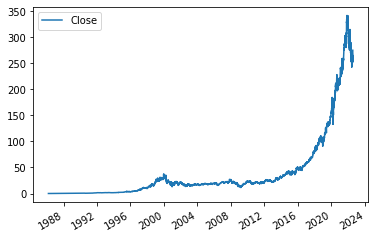

In [26]:
#plotting the data
msft_hist.plot.line(y="Close", use_index=True)

In [27]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [28]:
#Displaying the Actual_Close & Target
data.head(5)

,Actual_Close,Target
1986-03-13,0.061109,NaN
1986-03-14,0.063292,1.0
1986-03-17,0.064383,1.0
1986-03-18,0.062746,0.0
1986-03-19,0.061655,0.0


In [29]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [30]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

# Applying machine learning model


In [46]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [47]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4659090909090909

<AxesSubplot:>

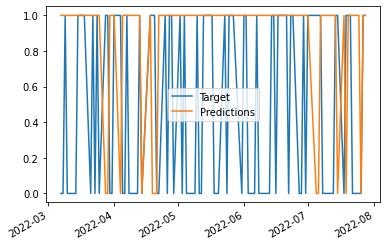

In [48]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [79]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [80]:
predictions = backtest(data, model, predictors)


In [81]:
predictions["Predictions"].value_counts()

0.0    7450
1.0     718
Name: Predictions, dtype: int64

In [82]:
predictions["Target"].value_counts()


1.0    4141
0.0    4027
Name: Target, dtype: int64

In [83]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5083565459610028

# perfecting the accuarcy 

In [84]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [88]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [85]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [86]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [89]:
data["weekly_trend"] = weekly_trend

In [90]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [98]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "High"]

In [99]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [100]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5338345864661654

# Evaluating the predictions we got

In [101]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7537
1.0     266
Name: Predictions, dtype: int64

<AxesSubplot:>

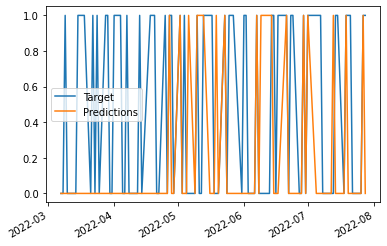

In [107]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()

